Dimensional Analysis (DA) is a powerful method of anaysis that uses units of measure associated with the quantities under consideration to derive fundamental characteristics of a system or process. While typically used in the sciences, DA can also be used in quantitative finance. [The Market Impact Puzzle](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3124502) by Kyle and Obizhaeva used DA to examine market impact at a fundamental level. This Jupyter notebook uses the python libary [Sympy](https://www.sympy.org/en/index.html) and a library for dimensional analysis - [Buckinghampy](https://github.com/ian-r-rose/buckinghampy) as described in the blog post on the subject by [Ian Rose](https://ian-r-rose.github.io/automated-dimensional-analysis.html) - to demonstrates DA in practice. The analysis is based on that in [Pohl et al](https://arxiv.org/abs/1702.05434) which further elaborated on Kyle and Obizhaeva.

Here is code from [Buckinghampy](https://github.com/ian-r-rose/buckinghampy).

In [1]:
import sympy
sympy.init_printing()

In [2]:
from sympy.matrices import Matrix
from sympy.solvers.solvers import solve_linear_system, solve_linear_system_LU

from collections import OrderedDict
from IPython.display import display, Math, Latex

In [3]:
class Parameter(object):
    def __init__(self,symbol,units):
        self.symbol = symbol
        self.units = units

In [4]:
def construct_dimension_matrix( parameters ):
    # Storing the units in a set means that we ignore
    # duplicate units, and will just have a set of all
    # the units which appear at least once in the problem:
    units = set()
    for p in parameters:
        for key in p.units:
            units.add(key)

    # The downside of a set is that it is unordered. It is
    # nice to have the units be alphabetized for easier 
    # inspection of the matrix, so we convert the units 
    # set to a list, then alphabetize that.
    units =list(units)
    units.sort()

    #Construct a matrix of the appropriate shape
    dimension_matrix = sympy.zeros( len(units), len(parameters) )
    
    for i,u in enumerate(units):
        for j,p in enumerate(parameters):
            # Determine the matrix entry for i,j
            # If the unit appears in the parameter,
            # then it is the power of that unit,
            # otherwise it is zero
            entry = p.units[u] if u in p.units else 0
            dimension_matrix[i,j] = entry

    return units, dimension_matrix

In [5]:
def construct_ordered_dimension_matrix( parameters, ordered_units):
    #Construct a matrix of the appropriate shape
    dimension_matrix = sympy.zeros( len(ordered_units), len(parameters) )
    
    for i,u in enumerate(ordered_units):
        for j,p in enumerate(parameters):
            # Determine the matrix entry for i,j
            # If the unit appears in the parameter,
            # then it is the power of that unit,
            # otherwise it is zero
            entry = p.units[u] if u in p.units else 0
            dimension_matrix[i,j] = entry

    return ordered_units, dimension_matrix

In [6]:
def parse_units(parameters, vector):
    # Initialize two empty strings for the numerator and 
    # denominator of the nondimensional number
    numerator_string = ''
    denominator_string = ''

    for p,n in zip(parameters, vector):
        # No need to typeset the parameters if they do not 
        # appear in the nondimensional number
        if n == 0:
            continue
        # If the exponent on the parameter is one,
        # we do not need to write it.
        if n == 1 or n == -1:
            parsed_parameter = p.symbol
        # If the exponent is a whole number, we do
        # not need to represent it as a fraction.
        elif n.q == 1 or n.q == -1:
            parsed_parameter = p.symbol + \
                    '^{%i}'%(abs(n.p))
        # Otherwise, represent it as a fraction
        else:
            parsed_parameter = p.symbol + \
                    '^{%i/%i}'%(abs(n.p), abs(n.q))

        # Depending upon whether the exponent is positive or 
        # negative, put it in the numerator or the denominator
        if n > 0:
            numerator_string = ' '\
                .join([numerator_string, parsed_parameter])
        elif n < 0:
            denominator_string = ' '\
                .join([denominator_string, parsed_parameter])

    # If the numerator is empty, make it a one
    if numerator_string == '':
        parsed_number = '\\frac{1}{'+denominator_string+'}'
    # If the denominator is empty, there is no need for a fraction
    elif denominator_string == '':
        parsed_number = numerator_string
    # Otherwise make it a fraction
    else:
        parsed_number = '\\frac{'+numerator_string+\
                        '}{'+denominator_string+'}'

    # And we are done! We return a LaTeX string
    return parsed_number
    
class NondimensionalNumber(object):
    def __init__(self, parameters, nondimensional_vector):
        self.parameters = parameters
        self.vector = nondimensional_vector
        self.string_representation = self._parse_nondimensional_number()
        
    def _parse_nondimensional_number(self):
        return parse_units(self.parameters, self.vector)
    
    # Let IPython know how this may be typeset with LaTeX
    def _repr_latex_(self):
        return '$$'+self.string_representation+'$$'
    # Return the string form of the nondimensional number
    def __str__(self):
        return self.string_representation

# This is a bit of a hack: Here I am subclassing
# the builtin Python list type and adding a
# function for print_latex(). This allows
# IPython to be able to render a list of 
# nondimensional numbers as well as a single one.
class NondimensionalNumberList(list):
    # Make a comma delimited list of the 
    # nondimensional numbers
    def __str__(self):
        string_representation = ''
        for n in range(len(self)):
            s = str(self.__getitem__(n))
            string_representation += s
            if n != len(self)-1:
                string_representation += ', '
        return string_representation
    
    #Add symbols for typesetting with LaTeX
    def print_latex(self):
        return '$$'+self.__str__()+'$$' 

In [7]:
# Register the print function with IPython
_ = get_ipython().display_formatter.formatters['text/latex'].\
    for_type(NondimensionalNumberList, \
             NondimensionalNumberList.print_latex)

In [8]:
def find_nondimensional_numbers( parameters ):
    # First, create the dimension matrix
    units, dimension_matrix = \
        construct_dimension_matrix(parameters)
    # Second, find the nullspace of the dimension matrix
    nullspace = dimension_matrix.nullspace()
    # Third, convert the vectors in the 
    # nullspace to nondimensional numbers
    nondimensional_numbers = NondimensionalNumberList(\
                [NondimensionalNumber(parameters, v) \
                 for v in nullspace])
    # Finally, return the list of nondimensional numbers
    return nondimensional_numbers

Define some units to implement the analysis in [Pohl et al](https://arxiv.org/abs/1702.05434).

In [9]:
# Q [shares] meta-order
# P [money] price
# V [shared/time] volume
# \\sigma^2 [time^-1] variance
order = Parameter('Q',{'s':1})
price = Parameter('P',{'u':1,'s':-1})
volume = Parameter('V',{'s':1,'t':-1})
variance = Parameter(r'\sigma^2',{'t':-1})

Need to annotate but ... time.

In [10]:
p1 = [order,price,volume,variance]

In [11]:
units, dimension_matrix = construct_dimension_matrix(p1)

In [12]:
units

['s', 't', 'u']

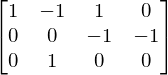

In [13]:
dimension_matrix

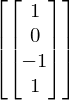

In [14]:
nullspace = dimension_matrix.nullspace()
nullspace

In [15]:
nomdim = find_nondimensional_numbers(p1)
nomdim

In [16]:
# C [money] cost
cost = Parameter('C',{'u':1})
p2 = [order,price,volume,variance,cost]

In [17]:
u2, dm2 = construct_dimension_matrix(p2)

In [18]:
u2

['s', 't', 'u']

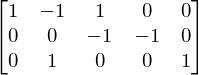

In [19]:
dm2

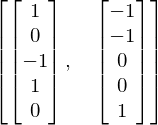

In [20]:
ns2 = dm2.nullspace()
ns2

In [21]:
nd2 = find_nondimensional_numbers(p2)
nd2

In [22]:
order = Parameter('Q',{'s':1})
price = Parameter('P',{'u':1,'s':-1,'m':-1})
volume = Parameter('V',{'s':1,'t':-1})
variance = Parameter(r'(\sigma^2)',{'t':-1,'m':2})

In [23]:
p3 = [order,price,volume,variance]

In [24]:
u3,dm3 = construct_dimension_matrix(p3)

In [25]:
u3

['m', 's', 't', 'u']

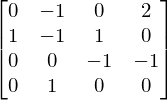

In [26]:
dm3

In [27]:
b = Matrix(4,1,[1,0,0,0])

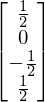

In [28]:
dm3.LUsolve(b)

In [29]:
nd3 = find_nondimensional_numbers(p3)
nd3

In [30]:
cost = Parameter('C',{'u':1})
p4 = [order,price,volume,variance,cost]

In [31]:
u4,dm4 =  construct_ordered_dimension_matrix(p4,['s','u','t','m'])

In [32]:
u4

['s', 'u', 't', 'm']

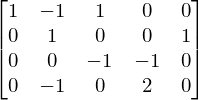

In [33]:
dm4

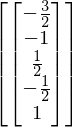

In [34]:
ns4 = dm4.nullspace()
ns4

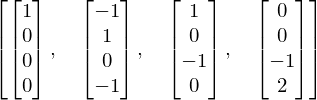

In [35]:
dm4.columnspace()

In [36]:
nd4 = find_nondimensional_numbers(p4)
nd4

In [37]:
from sympy import linsolve, symbols

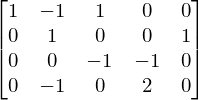

In [38]:
dm4

In [39]:
b = Matrix(4,1,[0,0,0,1])
b

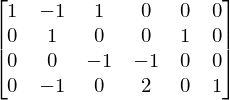

In [40]:
t4 = dm4.col_insert(dm4.shape[1],b)
t4

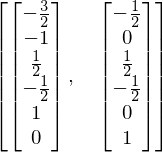

In [41]:
t4.nullspace()

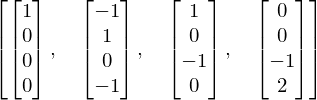

In [42]:
t4.columnspace()

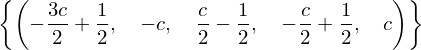

In [43]:
ts4 = linsolve(t4,symbols('q p v s2 c g'))
ts4

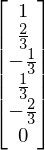

In [44]:
t4.nullspace()[0]*-2/3

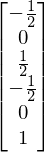

In [45]:
t4.nullspace()[1]

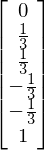

In [46]:
(t4.nullspace()[0]*-1/3)+t4.nullspace()[1]

In [47]:
sv = t4.nullspace()
sv[1][0].p, sv[1][1].q

In [48]:
impact = Parameter('G',{'m':1})
p5 = [order,price,volume,variance,cost,impact]
nd5 = find_nondimensional_numbers(p5)
nd5

In [49]:
Latex('$$ {0} $$'.format(parse_units(p5[:5],sv[1])))

<IPython.core.display.Latex object>

In [50]:
Latex('$$ {0} $$'.format(parse_units(p5[:5],(sv[0]*-1/3)+sv[1])))

<IPython.core.display.Latex object>

In [51]:
Latex('$$ {0} $$'.format(parse_units(p5[:5],(sv[0]*-1)+sv[1])))

<IPython.core.display.Latex object>

In [52]:
Latex('$$ {0} $$'.format(parse_units(p5[:5],(sv[0])+sv[1])))

<IPython.core.display.Latex object>